#### compare forcing quantities for ERA5 and MetOffice and NCEP

Objective/problem description:
- TOM12 can use 2 physical forcing parameterizations, CORE and CLIO, which differ in ways I don’t fully understand, CORE is generally assumed to be ‘better’, or more advanced
- CORE can be used with MetOffice data or with ERA5 data, CLIO is used with NCEP


I’ve run two runs: 
- TOM12_TJ_T001/TOM12_TJ_NC02
        - basically one run but stopped output halfway thru bc filespace, uses NCEP/ CLIO
- TOM12_TJ_M001
        - same as above, only difference is that it uses CORE and MetOffice data


In this notebook, we want to know:	

- How different are the different sets of forcing?
- Are ERA5 and MetOffice comparable products? How do they compare to NCEP?
- Eventually/next step: What are the overarching patterns in the two long runs and how do they differ between the 2 runs, ie how does using different forcing affect the TOM12 output? 


#### prelim. notes
- units check out, nothing too shocking in fields, ERA & MO are broadly comparable
- there are differences between the products
- I don't understand humidity, but it is comparable between ERA & MO


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

##### table comparing MetOffice and Era forcing variables

| model varname | what it is | era5 fn pattern | era5 varname (short) | units (unit check) | MO varname (short) |  |
| --- | --- | --- | --- | --- | --- | --- |
| sn_wndi | wind speed i  | taux_1d | uflx | m/s | MetOffice_wind | uwind10m |
| sn_wndj | wind speed j | tauy_1d | vflx | m/s | MetOffice_wind | vwind10m |
| sn_qsr | shortwave radiation | era5_bulk_11 | rsds | W/m^2 | MetOffice_sw_down | sw_down |
| sn_qlw | longwave rad | era5_bulk_12 | rlds | W/m^2 | MetOffice_lw_down | lw_down |
| sn_tair | air temp | era5_bulk_8 | air | degK | MetOffice_tair10m | tair10m |
| sn_humi | humidity | era5_bulk_9 | shum | kg kg-1 | MetOffice_qair10m | qair10m |
| sn_prec | precipitation (all) | era5_bulk_13 | prra | kg/m^2/s | MetOffice_precip | precip |
| sn_snow | precip as snow | era5_bulk_14 | prsn | kg/m^2/s | MetOffice_snow | snow |
| sn_tdif | some stress diff | taudif_core | taudif |  |  |  |


- directly comparable (hopefully) between NCEP/CLIO and MO&ERA/CORE: 
    - air temperature, windspeed (by calculation), humidity, total precipitation
- ONLY NCEP/clio has tcdc (total cloud cover)
- ONLY MO&ERA/core has: shortwave, longwave, snow precipitation
- NCEP has windstress, MO/ERA has u and v wind velocity, not directly comparable


In [3]:
## TJ: landmask, broadcast to 365 days

w = nc.Dataset('../UTILS/sector_landmask.nc')  
sectormask = (w['sectormask'][:])
topend = 37
sm_so = sectormask[0:topend,:]
print(np.shape(sm_so))
sm_broad = np.zeros([365,topend,182])
for i in range(0,365):
    sm_broad[i,:,:] = sm_so

(37, 182)


In [4]:
## TJ: define a function to get out yearly summer and winter forcing, works for era, ncep, and met office
## apply to all forcing for all products and save as pkl
    
def forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam, topend = 37, verbose = False):

    '''
    topend is the top lattitude indicator, 37 is around 50, that's the default
    '''
    yrs = np.arange(yrstart,yrend+1,1)

    tq_sum_bylat = np.zeros([topend,len(yrs)])
    tq_wint_bylat = np.zeros([topend,len(yrs)])
        
    for i in range(0,len(yrs)):

        yr = yrs[i]
        if (i%10 == 0): 
            print(yr)
        w = glob.glob(f'{tdir}/*{ncnam}*{yr}.nc')
        tnam = (w[0])
        if verbose:
            print(tnam)
        w = nc.Dataset(tnam)
        tq = w[varnam]
        
        #get summer and winter
        wint_tq = (tq[151:243,0:topend,:])
        sum1_tq = tq[0:59,0:topend,:]
        sum2_tq = tq[334:365,0:topend,:]
        sum_tq = np.concatenate([sum1_tq,sum2_tq], axis =0 )
        sum_tq[sm_broad[0:90,:,:]==1]=np.nan
        wint_tq[sm_broad[0:92,:,:]==1]=np.nan
        
        sum_mean = np.nanmean(np.nanmean(sum_tq, axis = 0),axis = 1)
        wint_mean = np.nanmean(np.nanmean(wint_tq, axis = 0),axis = 1)
        tq_sum_bylat[:,i] = sum_mean
        tq_wint_bylat[:,i] = wint_mean
    return tq_sum_bylat, tq_wint_bylat


In [5]:
runhorse = False

tdir = '/gpfs/data/greenocean/software/products/MetOffice/withOzone/'
ncnam = 'MetOffice_wind'
ncshort = 'MO'
varnam = 'uwind10m'
yrstart = 1950
yrend = 2020

if runhorse:
    tdir = '/gpfs/data/greenocean/software/products/MetOffice/withOzone/'
    yrstart = 1950
    yrend = 2020

    ncnam = 'MetOffice_wind'
    ncshort = 'MO'
    varnam = 'uwind10m'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    varnam = 'vwind10m'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    ncnam = 'MetOffice_sw_down'
    varnam = 'sw_down'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    ncnam = 'MetOffice_lw_down'
    varnam = 'lw_down'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'MetOffice_tair10m'
    varnam = 'tair10m'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'MetOffice_qair10m'
    varnam = 'qair10m'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'MetOffice_precip'
    varnam = 'precip'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'MetOffice_snow'
    varnam = 'snow'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)

In [6]:
runhorse = False

yrstart = 1950
yrend = 2020

if runhorse:
    tdir = '/gpfs/data/greenocean/software/products/ERA5Forcing/daily/'
    ncshort = 'ERA5daily'


    ncnam = 'taux_1d'
    varnam = 'uflx'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    ncnam = 'tauy_1d'
    varnam = 'vflx'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    ncnam = 'era5_bulk_11'
    varnam = 'rsds'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    ncnam = 'era5_bulk_12'
    varnam = 'rlds'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'era5_bulk_8'
    varnam = 'air'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'era5_bulk_9'
    varnam = 'shum'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'era5_bulk_13'
    varnam = 'prra'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)
    
    ncnam = 'era5_bulk_14'
    varnam = 'prsn'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)

In [7]:
runhorse = False

yrstart = 1950
yrend = 2020

if runhorse:
    tdir = '/gpfs/data/greenocean/software/products/NCEPForcingData/'
    ncshort = 'NCEP'


    ncnam = 'taux_1d'
    varnam = 'uflx'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    ncnam = 'tauy_1d'
    varnam = 'vflx'
    now = datetime.now()
    print(now)
    tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
#     ncnam = 'ncep_bulk'
#     varnam = 'wspd'
#     now = datetime.now()
#     print(now)
#     tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
#     fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_wint, open(fn, 'wb'))
#     fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_sum, open(fn, 'wb'))
#     now2 = datetime.now()
#     print(now2-now) 
    
#     ncnam = 'ncep_kelvin'
#     varnam = 'air'
#     now = datetime.now()
#     print(now)
#     tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
#     fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_wint, open(fn, 'wb'))
#     fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_sum, open(fn, 'wb'))
#     now2 = datetime.now()
#     print(now2-now)
    
#     ncnam = 'ncep_bulk'
#     varnam = 'humidity'
#     now = datetime.now()
#     print(now)
#     tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
#     fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_wint, open(fn, 'wb'))
#     fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_sum, open(fn, 'wb'))
#     now2 = datetime.now()
#     print(now2-now)
    
#     ncnam = 'ncep_bulk'
#     varnam = 'tcdc'
#     now = datetime.now()
#     print(now)
#     tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
#     fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_wint, open(fn, 'wb'))
#     fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
#     pickle.dump(tq_sum, open(fn, 'wb'))
#     now2 = datetime.now()
#     print(now2-now)
    
    # ncnam = 'ncep_bulk'
    # varnam = 'prate'
    # now = datetime.now()
    # print(now)
    # tq_sum, tq_wint = forcing_bylat_winter_summer_quantav(yrstart, yrend, tdir, ncnam, varnam)
    # fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    # pickle.dump(tq_wint, open(fn, 'wb'))
    # fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    # pickle.dump(tq_sum, open(fn, 'wb'))
    # now2 = datetime.now()
    # print(now2-now)
    

In [8]:
#tq_sum

In [9]:
# TJ get Windspeed out from ERA and MO
def wspd_bylat_winter_summer_quantav_ERA(yrstart, yrend, tdir, topend = 37, verbose = False):

    '''
    for metoffice and era5 that don't have wspd
    '''
    yrs = np.arange(yrstart,yrend+1,1)

    tq_sum_bylat = np.zeros([topend,len(yrs)])
    tq_wint_bylat = np.zeros([topend,len(yrs)])
        
    for i in range(0,len(yrs)):

        yr = yrs[i]
        if (i%10 == 0): 
            print(yr)
        w = glob.glob(f'{tdir}/tauy_1d_y{yr}*.nc')
        tnam = (w[0])
        MO = nc.Dataset(tnam)
        vwind10m = MO['vflx'][0:365,0:topend,:]
        
        w = glob.glob(f'{tdir}/taux_1d_y{yr}*.nc')
        tnam = (w[0])
        MO = nc.Dataset(tnam)
        uwind10m = MO['uflx'][0:365,0:topend,:]        
        wspd10m = np.sqrt(uwind10m**2+vwind10m**2) 
#         print(wspd10m[0,20,:])
        
        tq = wspd10m
        wint_tq = (tq[151:243,0:topend,:])
        sum1_tq = tq[0:59,0:topend,:]
        sum2_tq = tq[334:365,0:topend,:]
        sum_tq = np.concatenate([sum1_tq,sum2_tq], axis =0 )
        sum_tq[sm_broad[0:90,:,:]==1]=np.nan
        wint_tq[sm_broad[0:92,:,:]==1]=np.nan        

        sum_mean = np.nanmean(np.nanmean(sum_tq, axis = 0),axis = 1)
        wint_mean = np.nanmean(np.nanmean(wint_tq, axis = 0),axis = 1)
        # print(sum_mean)
        # print(wint_mean)
        tq_sum_bylat[:,i] = sum_mean
        tq_wint_bylat[:,i] = wint_mean    
    return tq_sum_bylat, tq_wint_bylat

def wspd_bylat_winter_summer_quantav_MO(yrstart, yrend, tdir, topend = 37, verbose = False):

    '''
    for metoffice and era5 that don't have wspd
    '''
    yrs = np.arange(yrstart,yrend+1,1)
    tq_sum_bylat = np.zeros([topend,len(yrs)])
    tq_wint_bylat = np.zeros([topend,len(yrs)])
        
    for i in range(0,len(yrs)):

        yr = yrs[i]
        if (i%10 == 0): 
            print(yr)
        w = glob.glob(f'{tdir}/MetOffice_wind*{yr}*.nc')
        tnam = (w[0])
        MO = nc.Dataset(tnam)
        vwind10m = MO['vwind10m'][0:365,0:topend,:]
        uwind10m = MO['uwind10m'][0:365,0:topend,:]
        wspd10m = np.sqrt(uwind10m**2+vwind10m**2) 
        print(wspd10m[0,20,:])
        
        tq = wspd10m
        wint_tq = (tq[151:243,0:topend,:])
        sum1_tq = tq[0:59,0:topend,:]
        sum2_tq = tq[334:365,0:topend,:]
        sum_tq = np.concatenate([sum1_tq,sum2_tq], axis =0 )
        sum_tq[sm_broad[0:90,:,:]==1]=np.nan
        wint_tq[sm_broad[0:92,:,:]==1]=np.nan        

        sum_mean = np.nanmean(np.nanmean(sum_tq, axis = 0),axis = 1)
        wint_mean = np.nanmean(np.nanmean(wint_tq, axis = 0),axis = 1)
        tq_sum_bylat[:,i] = sum_mean
        tq_wint_bylat[:,i] = wint_mean    
    return tq_sum_bylat, tq_wint_bylat

runhorse = False
if runhorse:
    now = datetime.now()
    print(now)

    yrstart = 1950; yrend = 2020;
    tdir = '/gpfs/data/greenocean/software/products/ERA5Forcing/daily/'
    tq_sum_bylat, tq_wint_bylat = wspd_bylat_winter_summer_quantav_ERA(yrstart, yrend, tdir, topend = 37, verbose = False)
    varnam = 'wspd'
    ncshort = 'ERA5'
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)

    now = datetime.now()
    print(now)
    yrstart = 1950; yrend = 2020;
    tdir = '/gpfs/data/greenocean/software/products/MetOffice/withOzone/'
    tq_sum_bylat, tq_wint_bylat = wspd_bylat_winter_summer_quantav_MO(yrstart, yrend, tdir, topend = 37, verbose = False)
    ncshort = 'MO'
    varnam = 'wspd'
    fn = f'./pkls/{ncshort}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{ncshort}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    
    
    now2 = datetime.now()
    print(now2-now) 




In [10]:
## TJ open all the files back and start comparing them

##3way:

# directly comparable (hopefully) between NCEP/CLIO and MO&ERA/CORE: 
# air temperature, u-wind, v-wind, windspeed (by extension), humidity, total precipitation
# ONLY NCEP/clio has tcdc (total cloud cover)
# ONLY MO&ERA/core has: shortwave, longwave, snow precipitation

#hindcast2008_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2008_wind_mag.pkl', 'rb'))

NCEP_tair_sum = pickle.load(open('./pkls/NCEP_air_sum_1950-2020.pkl', 'rb'))
NCEP_tair_wint = pickle.load(open('./pkls/NCEP_air_wint_1950-2020.pkl', 'rb'))
NCEP_vflx_sum = pickle.load(open('./pkls/NCEP_vflx_sum_1950-2020.pkl', 'rb'))
NCEP_vflx_wint = pickle.load(open('./pkls/NCEP_vflx_wint_1950-2020.pkl', 'rb'))
NCEP_uflx_sum = pickle.load(open('./pkls/NCEP_uflx_sum_1950-2020.pkl', 'rb'))
NCEP_uflx_wint = pickle.load(open('./pkls/NCEP_uflx_wint_1950-2020.pkl', 'rb'))
NCEP_tcdc_sum = pickle.load(open('./pkls/NCEP_tcdc_sum_1950-2020.pkl', 'rb'))
NCEP_tcdc_wint = pickle.load(open('./pkls/NCEP_tcdc_wint_1950-2020.pkl', 'rb'))
NCEP_wspd_sum = pickle.load(open('./pkls/NCEP_wspd_sum_1950-2020.pkl', 'rb'))
NCEP_wspd_wint = pickle.load(open('./pkls/NCEP_wspd_wint_1950-2020.pkl', 'rb'))
NCEP_humidity_sum = pickle.load(open('./pkls/NCEP_humidity_sum_1950-2020.pkl', 'rb'))
NCEP_humidity_wint = pickle.load(open('./pkls/NCEP_humidity_wint_1950-2020.pkl', 'rb'))
NCEP_prec_sum = pickle.load(open('./pkls/NCEP_prate_sum_1950-2020.pkl', 'rb'))
NCEP_prec_wint = pickle.load(open('./pkls/NCEP_prate_wint_1950-2020.pkl', 'rb'))

MO_tair_sum = pickle.load(open('./pkls/MO_tair10m_sum_1950-2020.pkl', 'rb'))
MO_tair_wint = pickle.load(open('./pkls/MO_tair10m_wint_1950-2020.pkl', 'rb'))
MO_vflx_sum = pickle.load(open('./pkls/MO_vwind10m_sum_1950-2020.pkl', 'rb'))
MO_vflx_wint = pickle.load(open('./pkls/MO_vwind10m_wint_1950-2020.pkl', 'rb'))
MO_uflx_sum = pickle.load(open('./pkls/MO_uwind10m_sum_1950-2020.pkl', 'rb'))
MO_uflx_wint = pickle.load(open('./pkls/MO_uwind10m_wint_1950-2020.pkl', 'rb'))
MO_wspd_sum = pickle.load(open('./pkls/MO_wspd_sum_1950-2020.pkl', 'rb'))
MO_wspd_wint = pickle.load(open('./pkls/MO_wspd_wint_1950-2020.pkl', 'rb'))
MO_qair10m_sum = pickle.load(open('./pkls/MO_qair10m_sum_1950-2020.pkl', 'rb'))
MO_qair10m_wint = pickle.load(open('./pkls/MO_qair10m_wint_1950-2020.pkl', 'rb'))
MO_prec_sum = pickle.load(open('./pkls/MO_precip_sum_1950-2020.pkl', 'rb'))
MO_prec_wint = pickle.load(open('./pkls/MO_precip_wint_1950-2020.pkl', 'rb'))
MO_snow_sum = pickle.load(open('./pkls/MO_snow_sum_1950-2020.pkl', 'rb'))
MO_snow_wint = pickle.load(open('./pkls/MO_snow_wint_1950-2020.pkl', 'rb'))
MO_sw_down_sum = pickle.load(open('./pkls/MO_sw_down_sum_1950-2020.pkl', 'rb'))
MO_sw_down_wint = pickle.load(open('./pkls/MO_sw_down_wint_1950-2020.pkl', 'rb'))
MO_lw_down_sum = pickle.load(open('./pkls/MO_lw_down_sum_1950-2020.pkl', 'rb'))
MO_lw_down_wint = pickle.load(open('./pkls/MO_lw_down_wint_1950-2020.pkl', 'rb'))

ERA5daily_tair_sum = pickle.load(open('./pkls/ERA5daily_air_sum_1950-2020.pkl', 'rb'))
ERA5daily_tair_wint = pickle.load(open('./pkls/ERA5daily_air_wint_1950-2020.pkl', 'rb'))
ERA5daily_vflx_sum = pickle.load(open('./pkls/ERA5daily_vflx_sum_1950-2020.pkl', 'rb'))
ERA5daily_vflx_wint = pickle.load(open('./pkls/ERA5daily_vflx_wint_1950-2020.pkl', 'rb'))
ERA5daily_uflx_sum = pickle.load(open('./pkls/ERA5daily_uflx_sum_1950-2020.pkl', 'rb'))
ERA5daily_uflx_wint = pickle.load(open('./pkls/ERA5daily_uflx_wint_1950-2020.pkl', 'rb'))
ERA5daily_wspd_sum = pickle.load(open('./pkls/ERA5_wspd_sum_1950-2020.pkl', 'rb'))
ERA5daily_wspd_wint = pickle.load(open('./pkls/ERA5_wspd_wint_1950-2020.pkl', 'rb'))
ERA5daily_sw_down_sum = pickle.load(open('./pkls/ERA5daily_rsds_sum_1950-2020.pkl', 'rb'))
ERA5daily_sw_down_wint = pickle.load(open('./pkls/ERA5daily_rsds_wint_1950-2020.pkl', 'rb'))
ERA5daily_lw_down_sum = pickle.load(open('./pkls/ERA5daily_rlds_sum_1950-2020.pkl', 'rb'))
ERA5daily_lw_down_wint = pickle.load(open('./pkls/ERA5daily_rlds_wint_1950-2020.pkl', 'rb'))
ERA5daily_qair10m_sum = pickle.load(open('./pkls/ERA5daily_shum_sum_1950-2020.pkl', 'rb'))
ERA5daily_qair10m_wint = pickle.load(open('./pkls/ERA5daily_shum_wint_1950-2020.pkl', 'rb'))
ERA5daily_prec_sum = pickle.load(open('./pkls/ERA5daily_prra_sum_1950-2020.pkl', 'rb'))
ERA5daily_prec_wint = pickle.load(open('./pkls/ERA5daily_prra_wint_1950-2020.pkl', 'rb'))
ERA5daily_snow_sum = pickle.load(open('./pkls/ERA5daily_prsn_sum_1950-2020.pkl', 'rb'))
ERA5daily_snow_wint = pickle.load(open('./pkls/ERA5daily_prsn_wint_1950-2020.pkl', 'rb'))


In [11]:
## TJ prepare 2 grid
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001'
w = glob.glob(f'{tdir}/ORCA2_1m_20160101_20161231_ptrc_T.nc')
w2 = nc.Dataset(w[0])
lats = w2['nav_lat'][0:37,0]
yrs = np.arange(1950,2021,1)
yrsG, latsG = np.meshgrid(yrs,lats) 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


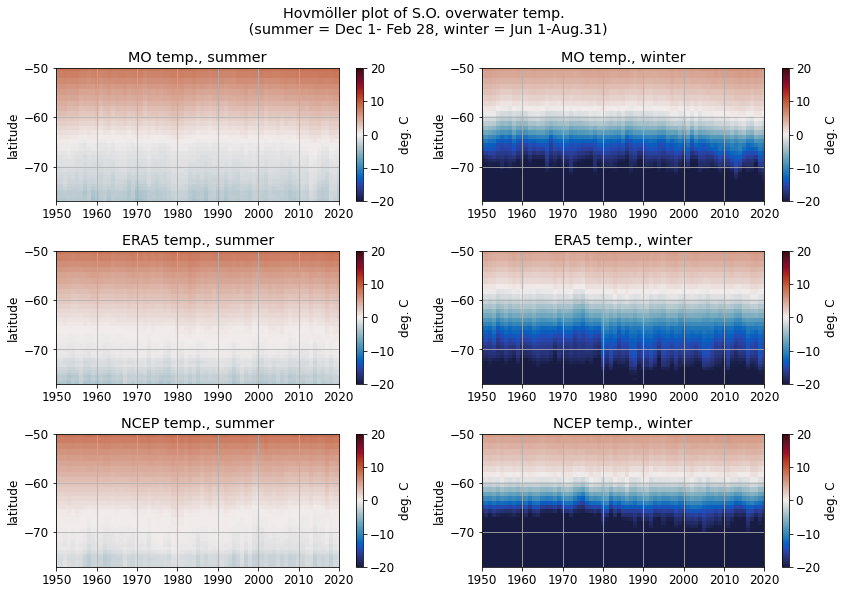

In [12]:
pbl = [MO_tair_sum, MO_tair_wint,\
      ERA5daily_tair_sum, ERA5daily_tair_wint,
      NCEP_tair_sum, NCEP_tair_wint]#, sal_wint_bylat, sal_sum_bylat, dic_wint_bylat*1e6, dic_sum_bylat*1e6]
cms = [cm.balance, cm.balance, cm.haline, cm.haline, cm.matter, cm.matter]

var = 'temp.'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']
#adjust kelvin to celsius
adj = 272.15

#
mins = -20
maxs = 20
cms = cm.balance
labs = 'deg. C'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

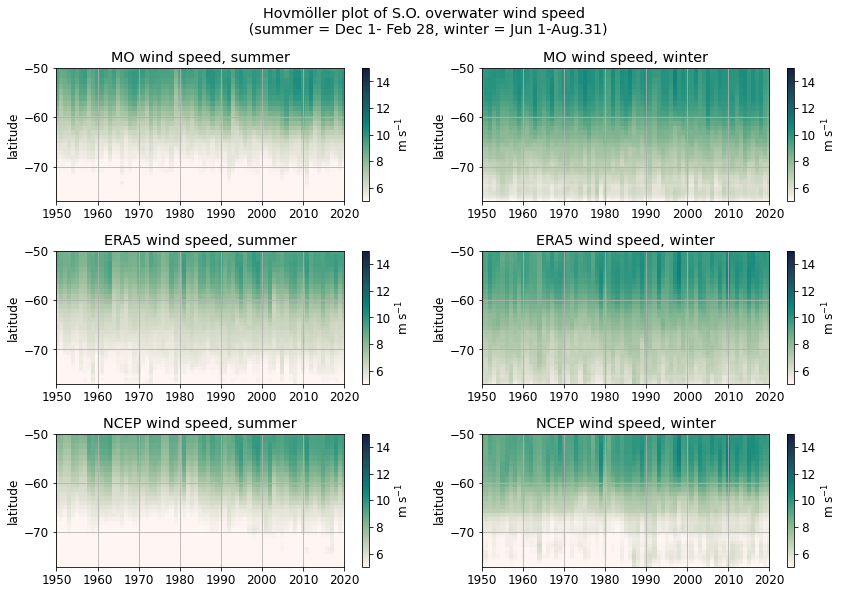

In [13]:



pbl = [MO_wspd_sum, MO_wspd_wint,\
      ERA5daily_wspd_sum, ERA5daily_wspd_wint,
      NCEP_wspd_sum, NCEP_wspd_wint]
cms = [cm.balance, cm.balance, cm.haline, cm.haline, cm.matter, cm.matter]

var = 'wind speed'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']

adj = 0

#
mins = 5
maxs = 15
cms = cm.tempo
labs = 'm s$^{-1}$'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

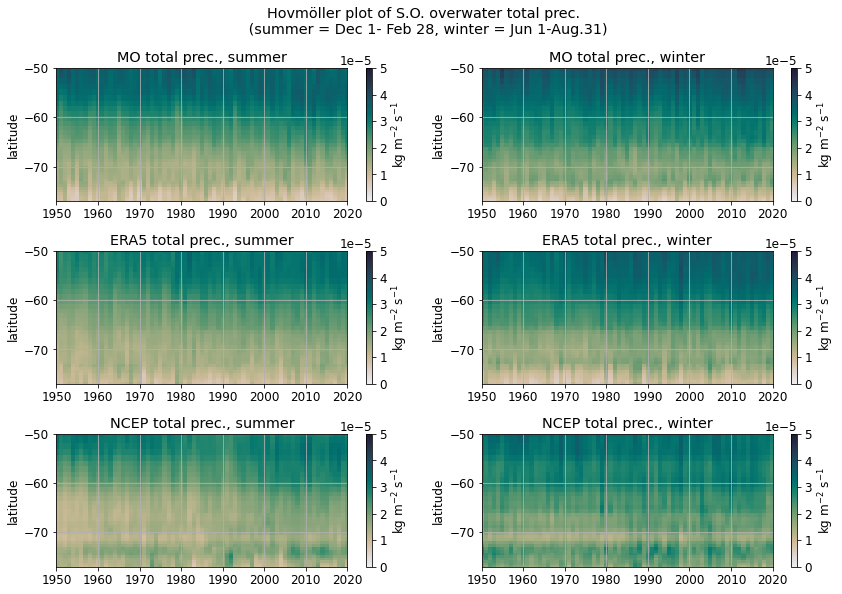

In [14]:
pbl = [MO_prec_sum, MO_prec_wint,\
      ERA5daily_prec_sum, ERA5daily_prec_wint,
      NCEP_prec_sum, NCEP_prec_wint]

var = 'total prec.'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']

adj = 0

#
mins = 0
maxs = 0.00005
cms = cm.rain
labs = 'kg m$^{-2}$ s$^{-1}$'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

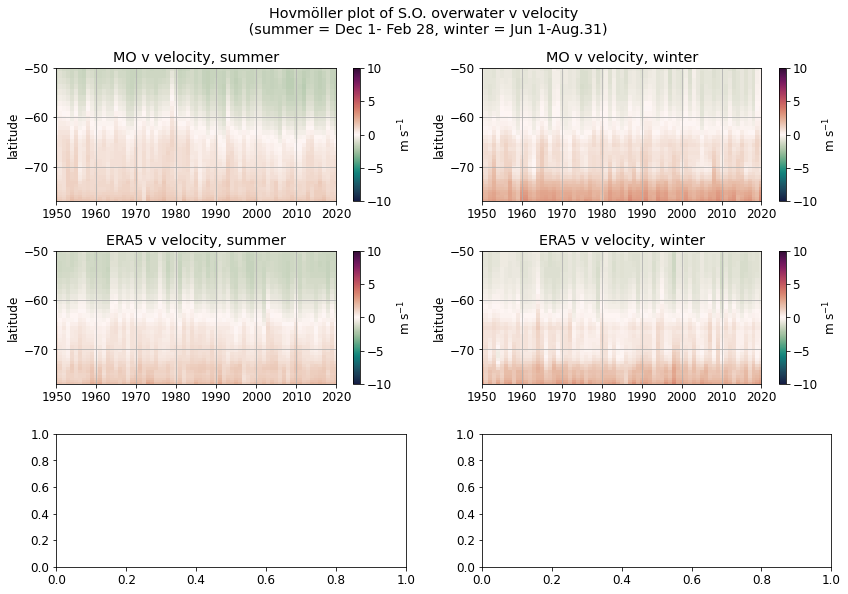

In [15]:



pbl = [MO_vflx_sum, MO_vflx_wint,\
      ERA5daily_vflx_sum, ERA5daily_vflx_wint,
      NCEP_uflx_sum, NCEP_uflx_wint]


var = 'v velocity'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']

adj = 0

#
mins = -10
maxs = 10
cms = cm.curl
labs = 'm s$^{-1}$'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,4):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

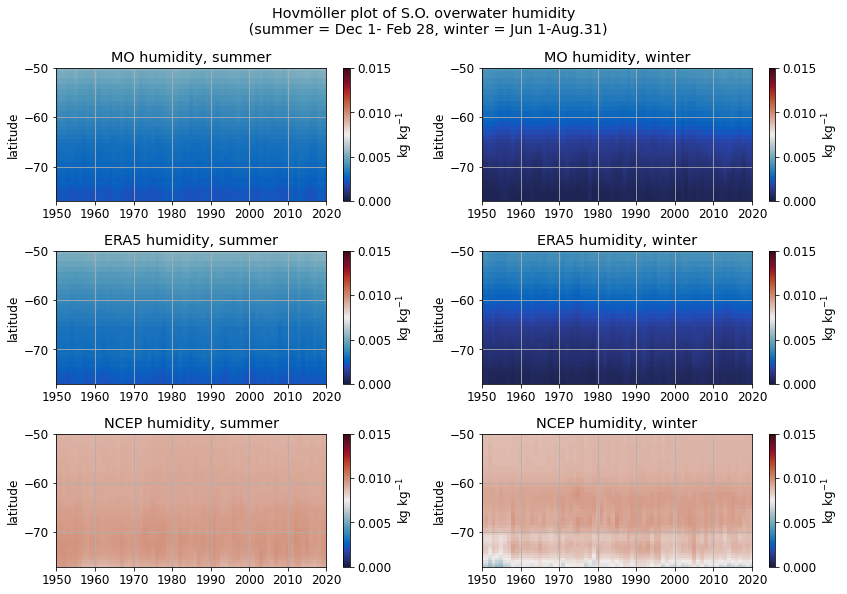

In [32]:



pbl = [MO_qair10m_sum, MO_qair10m_wint,\
      ERA5daily_qair10m_sum, ERA5daily_qair10m_wint,
      NCEP_humidity_sum/100, NCEP_humidity_wint/100]


var = 'humidity'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']

adj = 0

#
mins = 0.000
maxs = 0.015
cms = cm.balance
labs = 'kg kg$^{-1}$'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,4):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()
    
# mins = 0.8; maxs = 1.2
for i in range(4,6):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

In [27]:
print(np.nanmax(NCEP_humidity_sum))
print(np.nanmax(NCEP_humidity_wint))

0.981858491897583
1.2366557121276855


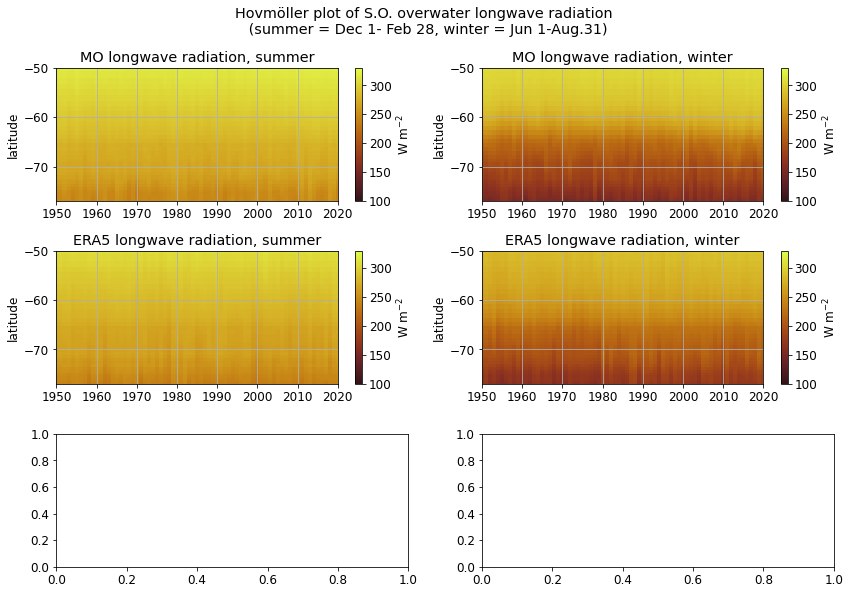

In [17]:
pbl = [MO_lw_down_sum, MO_lw_down_wint,\
      ERA5daily_lw_down_sum, ERA5daily_lw_down_wint,
      NCEP_uflx_sum, NCEP_uflx_wint]


var = 'longwave radiation'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']

adj = 0

#
mins = 0
maxs = 400
cms = cm.solar
labs = 'W m$^{-2}$'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,4):
    if (i == 1) | (i == 3):
        mins = 100; maxs = 330
    else:
        mins = 100; maxs = 330
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

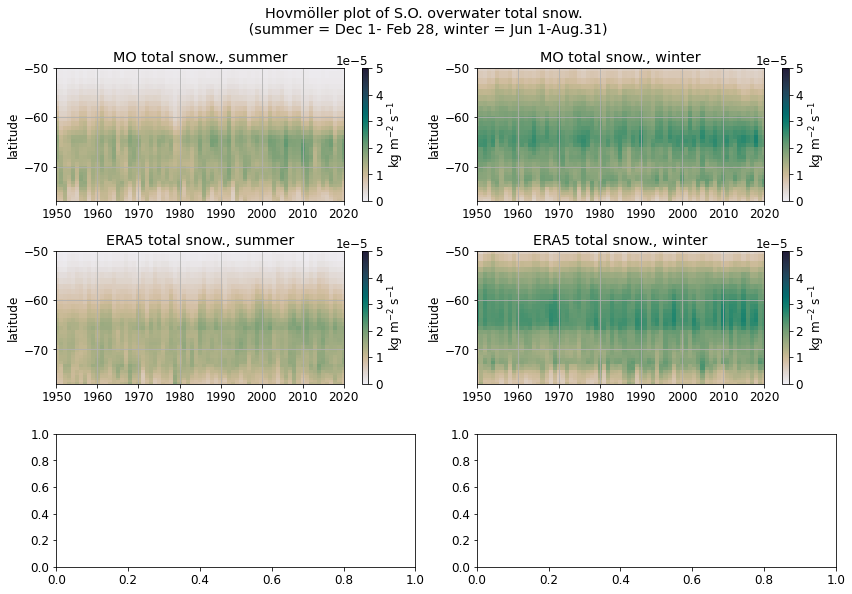

In [18]:
pbl = [MO_snow_sum, MO_snow_wint,\
      ERA5daily_snow_sum, ERA5daily_snow_wint]

var = 'total snow.'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']

adj = 0

#
mins = 0
maxs = 0.00005
cms = cm.rain
labs = 'kg m$^{-2}$ s$^{-1}$'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,4):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]-adj,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

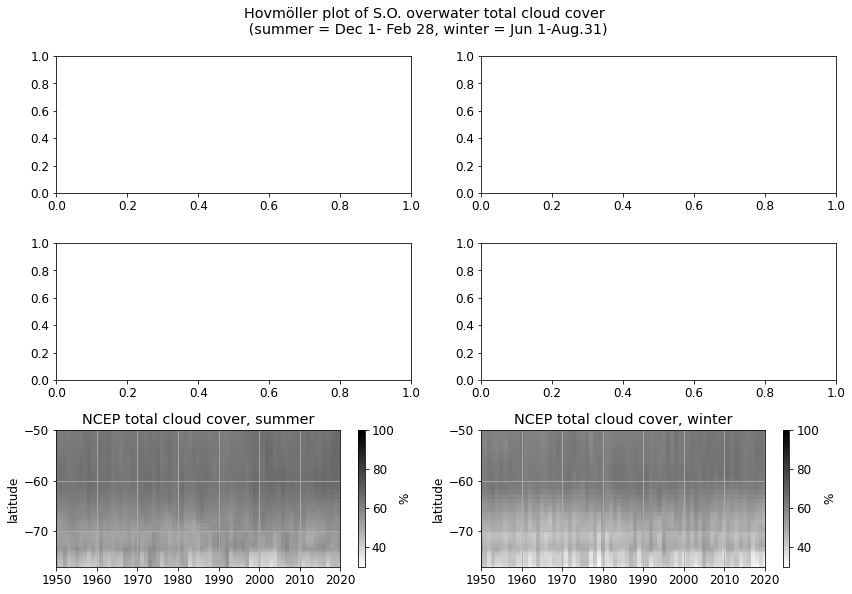

In [19]:
pbl = [NCEP_tcdc_sum, NCEP_tcdc_wint,\
      NCEP_tcdc_sum, NCEP_tcdc_wint,\
      NCEP_tcdc_sum, NCEP_tcdc_wint]

var = 'total cloud cover'
tits = [f'MO {var}, summer', f'MO {var}, winter',\
        f'ERA5 {var}, summer', f'ERA5 {var}, winter',
        f'NCEP {var}, summer', f'NCEP {var}, winter']#'winter sal.', 'summer sal.', 'winter DIC', 'summer DIC']
labs = ['deg C', 'deg C', 'g/kg', 'g/kg', 'umol/L', 'umol/L']

adj = 0

#
mins = 30
maxs = 100
cms = cm.gray_r
labs = '%'
fact = 0.6
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(4,6):
    w = axs[i].pcolormesh(yrsG, latsG, pbl[i]*100,
                  cmap = cms, vmin = mins, vmax = maxs)
    plt.colorbar(w, ax = axs[i], label = labs)
    axs[i].set_ylim([-77,-50])
    axs[i].set_xlim([1950,2020])
    axs[i].set_title(tits[i])
    axs[i].set_ylabel('latitude')
    axs[i].grid()

plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
plt.tight_layout()

#### I don't quite understand humidity units yet (stated as kg/kg in all netcdfs, don't clearly map)

In [20]:
tdir = '/gpfs/data/greenocean/software/products/NCEPForcingData/'
tfil = 'ncep_bulk_1992.nc'
w = nc.Dataset(f'{tdir}{tfil}')
print(f'path is {tdir}')
print(f'file is {tfil}')
print('var info')
print(w['humidity'])
print('at day 100, x 120, y 100')
print(w['humidity'][100,120,100])


path is /gpfs/data/greenocean/software/products/NCEPForcingData/
file is ncep_bulk_1992.nc
var info
<class 'netCDF4._netCDF4.Variable'>
float32 humidity(time_counter, y, x)
    long_name: mean Daily Specific Humidity at 2 m
    units: kg/kg
    short_name: shum
    axis: TYX
    interval_operation: 86400.0
    interval_write: 86400.0
    associate: time_counter nav_lat nav_lon
    missing_value: 1e+20
unlimited dimensions: time_counter
current shape = (366, 149, 182)
filling on, default _FillValue of 9.969209968386869e+36 used
at day 100, x 120, y 100
0.91717124


In [21]:
tdir = '/gpfs/data/greenocean/software/products/ERA5Forcing/daily/'
tfil = 'era5_bulk_9_y1992.nc'
w = nc.Dataset(f'{tdir}{tfil}')
print(f'path is {tdir}')
print(f'file is {tfil}')
print('var info')
print(w['shum'])
print('at day 100, x 120, y 100')
print(w['shum'][100,120,100])

path is /gpfs/data/greenocean/software/products/ERA5Forcing/daily/
file is era5_bulk_9_y1992.nc
var info
<class 'netCDF4._netCDF4.Variable'>
float32 shum(time_counter, y, x)
    units: kg/kg
    long_name: shum
    short_name: shum
    axis: TYX
    interval_operation: 86400.0
    interval_write: 86400.0
    associate: time_counter nav_lat nav_lon
    missing_value: 1e+20
unlimited dimensions: time_counter
current shape = (366, 149, 182)
filling on, default _FillValue of 9.969209968386869e+36 used
at day 100, x 120, y 100
0.00072950486


In [22]:
tdir = '//gpfs/data/greenocean/software/products/MetOffice/withOzone/'
tfil = 'MetOffice_qair10m1998.nc'
w = nc.Dataset(f'{tdir}{tfil}')
print(f'path is {tdir}')
print(f'file is {tfil}')
print('var info')
print(w['qair10m'])
print('at day 100, x 120, y 100')
print(w['qair10m'][100,120,100])

path is //gpfs/data/greenocean/software/products/MetOffice/withOzone/
file is MetOffice_qair10m1998.nc
var info
<class 'netCDF4._netCDF4.Variable'>
float64 qair10m(time_counter, y, x)
    long_name: Specific Humidity
    units: kg kg-1
    short_name: qair10m
    axis: TYX
    interval_operation: 86400.0
    interval_write: 86400.0
    associate: time_counter nav_lat nav_lon
    missing_value: 1e+20
unlimited dimensions: time_counter
current shape = (365, 149, 182)
filling on, default _FillValue of 9.969209968386869e+36 used
at day 100, x 120, y 100
0.0021431936252198423


In [23]:
print('max, summer, humidity, NCEP, MO, ERA5')
print(np.nanmax(NCEP_humidity_sum))
print(np.nanmax(MO_qair10m_sum))
print(np.nanmax(ERA5daily_qair10m_sum))
print('min, summer, humidity, NCEP, MO, ERA5')
print(np.nanmin(NCEP_humidity_sum))
print(np.nanmin(MO_qair10m_sum))
print(np.nanmin(ERA5daily_qair10m_sum))
print('max, wint, humidity, NCEP, MO, ERA5')
print(np.nanmax(NCEP_humidity_wint))
print(np.nanmax(MO_qair10m_wint))
print(np.nanmax(ERA5daily_qair10m_wint))
print('min, wint, humidity, NCEP, MO, ERA5')
print(np.nanmin(NCEP_humidity_wint))
print(np.nanmin(MO_qair10m_wint))
print(np.nanmin(ERA5daily_qair10m_wint))

max, summer, humidity, NCEP, MO, ERA5
0.981858491897583
0.0055505837025083314
0.0055280826054513454
min, summer, humidity, NCEP, MO, ERA5
0.8598858118057251
0.0018844605524204457
0.0019257153617218137
max, wint, humidity, NCEP, MO, ERA5
1.2366557121276855
0.00442228541771332
0.0043493350967764854
min, wint, humidity, NCEP, MO, ERA5
0.35054948925971985
0.0002587732827071051
0.00027256790781393647


In [24]:
print('compute complete: beep boop.')

compute complete: beep boop.
